Aluno: **Francisco Eudázio Suriano da Silva Júnior**

Professor: **Tiago Morkis Siqueira**

Disciplina: **Análise Não Linear de Estruturas**

Este programa foi desenvolvido em Python utilizando Jupyter Notebooks.

In [1]:
# Bibliotecas
import math
import numpy as np
import matplotlib.pyplot as plt
import copy

# Entrada de dados

In [2]:
fator = 1   # Fator para visualização dos resultados

# Propriedades do material:
E = 1e3     # Módulo de elasticidade inicial (N/m²)
A = 1       # Área das barras (m²)
fy = 4      # Tensão de escoamento do material (Pa)
K = 111     # Parâmetro do encruamento

# Configurações da análise não linear:
steps = 10  # Passos
tolF = 2e-3 # Tolerância em força
tolD = 2e-5 # Tolerância em deslocamento
nmax = 1e4  # Número máximo de iterações permitidas por passo

# Coordenadas dos nós [x, y]:
nodes = np.array([[0, 0], [10, 0], [20, 0], [0, 10], [10, 10], [20, 10], [0, 20], [10, 20], [20, 20]])
#nodes = np.array([[-100 * math.sqrt(3), 100], [0, 100],
#                  [100 * math.sqrt(3), 100], [0, 0]]) # Exemplo da aula 4

# Elementos [nó inicial, nó final]:
members = np.array([
                    # Horizontais:
                    [1, 2], [2, 3], [4, 5], [5, 6], [7, 8], [8, 9],
                    
                    # Verticais:
                    [1, 4], [4, 7], [2, 5], [5, 8], [3, 6], [6, 9],
                    
                    # Diagonais:
                    [2, 4], [2, 6], [4, 8], [6, 8]
                    ])
#members = np.array([[1, 4], [2, 4], [3, 4]]) # Exemplo da aula 4

# Ações externas (em Newtons, incluir no índice do grau de liberdade desejado):
nDoF = np.amax(members) * 2                # Número de graus de liberdade do problema (não alterar)
forceVector = np.array([np.zeros(nDoF)]).T # Cria o vetor de forças (não alterar)
forceVector[0] = -10
forceVector[16] = 10

# Condições de contorno (índices dos graus de liberdade impedidos pelos apoios):
restrainedIndex = [4, 5, 8, 9, 12, 13]

#=========================FIM DA ENTRADA DE DADOS=========================#

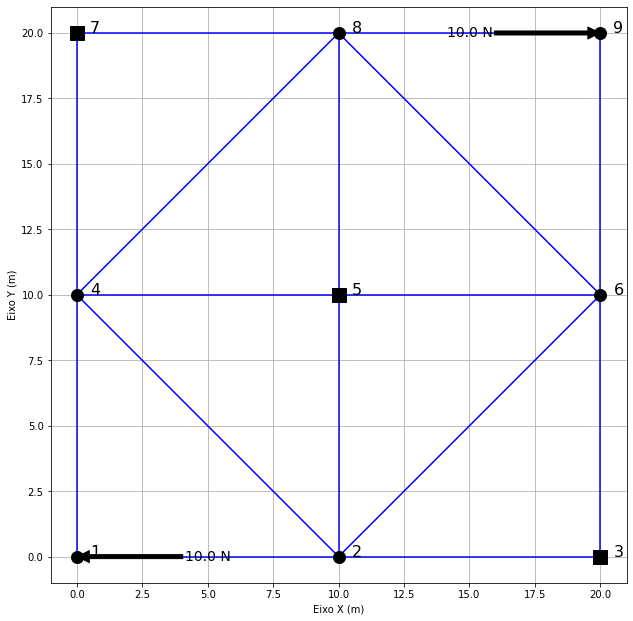

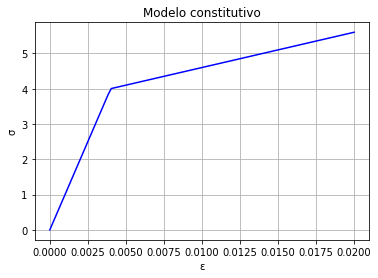

In [3]:
# Exibir estrutura definida:
magn = np.amax(nodes) # Grau de magnitude da estrutura, para plotagem dos textos
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 2,2])
fig.gca().set_aspect('equal', adjustable='box')

# Plotar elementos:
for mbr in members:
    node_i = mbr[0]           # Nó inicial do elemento
    node_j = mbr[1]           # Nó final do elemento
    ix = nodes[node_i - 1, 0] # Coordenada x do nó inicial
    iy = nodes[node_i - 1, 1] # Coordenada y do nó inicial
    jx = nodes[node_j - 1, 0] # Coordenada x do nó final
    jy = nodes[node_j - 1, 1] # Coordenada y do nó final
    
    axes.plot([ix, jx], [iy, jy], 'b')
        
# Plotar nós
dof = 0 # Grau de liberdade
num = 1 # Número do nó

for node in nodes:
    # Verifica se o nó tem algum grau de liberdade restringido:
    if dof in restrainedIndex and dof+1 in restrainedIndex: # Restrição em X e Y plota um quadrado
        axes.plot([node[0]], [node[1]], 'ks', ms=14)
    elif dof in restrainedIndex:                            # Restrição somente em X plota um triângulo virado
        axes.plot([node[0]], [node[1]], 'k>', ms=14)
    elif dof+1 in restrainedIndex:                          # Restrição somente em Y plota um triângulo
        axes.plot([node[0]], [node[1]], 'k^', ms=14)
    else:                                                   # Nó sem restrições plota um círculo
        axes.plot([node[0]], [node[1]], 'ko', ms=12)
    
    axes.text(node[0] + magn/40, node[1], num, size=16)
    
    # Desenhar seta com a força externa:
    if forceVector[dof] > 0: # Força positiva em X (para a direita)
        axes.annotate(f'{float(forceVector[dof])} N',
                      horizontalalignment = 'center',
                      verticalalignment = 'center',
                      xytext = (node[0] - magn/4, node[1]),
                      xy = (node[0] - magn/1000, node[1]),
                      arrowprops = dict(facecolor = 'black', shrink = 1),
                      size=14)
    if forceVector[dof] < 0: # Força negativa em X (para a esquerda)
        axes.annotate(f'{float(-forceVector[dof])} N',
                      horizontalalignment = 'center',
                      verticalalignment = 'center',
                      xytext = (node[0] + magn/4, node[1]),
                      xy = (node[0] + magn/1000, node[1]),
                      arrowprops = dict(facecolor = 'black', shrink = 1),
                      size=14)
    if forceVector[dof+1] > 0: # Força positiva em Y (para cima)
        axes.annotate(f'{float(forceVector[dof+1])} N',
                      horizontalalignment = 'center',
                      verticalalignment = 'center',
                      xytext = (node[0], node[1] - magn/4),
                      xy = (node[0], node[1] - magn/1000),
                      arrowprops = dict(facecolor = 'black', shrink = 1),
                      size=14)
    if forceVector[dof+1] < 0: # Força negativa em Y (para baixo)
        axes.annotate(f'{float(-forceVector[dof+1])} N',
                      horizontalalignment = 'center',
                      verticalalignment = 'center',
                      xytext = (node[0], node[1] + magn/4),
                      xy = (node[0], node[1] + magn/1000),
                      arrowprops = dict(facecolor = 'black', shrink = 1),
                      size=14)

    dof += 2
    num += 1

# Legenda dos eixos:
axes.set_xlabel('Eixo X (m)')
axes.set_ylabel('Eixo Y (m)')
axes.grid()
plt.show()

# Gráfico do modelo constitutivo:
t = []                        # Lista com as tensões
e = np.linspace(0, 0.02, 100) # Intervalo de deformações
ey = fy / E                   # Deformação de escoamento
Et = E * K/(E + K)            # Módulo tangente

for n in e:
    if n <= ey:
        t.append(E * n)              # Trecho linear elástico
    else:
        t.append(fy + Et * (n - ey)) # Encruamento

plt.plot(e, t, c='b')
plt.title('Modelo constitutivo')
plt.xlabel('ε')
plt.ylabel('σ')
plt.grid()
plt.show()

# Funções

In [4]:
# Orientação e comprimento dos elementos:
def memberOrientation(member):
    node_i = mbr[0]                   # Nó inicial do elemento
    node_j = mbr[1]                   # Nó final do elemento
    xi = nodes[node_i - 1, 0]         # Posição inicial do grau de liberdade horizontal do nó i
    yi = nodes[node_i - 1, 1]         # Posição inicial do grau de liberdade vertical do nó i
    xj = nodes[node_j - 1, 0]         # Posição inicial do grau de liberdade horizontal do nó j
    yj = nodes[node_j - 1, 1]         # Posição inicial do grau de liberdade vertical do nó j
    
    # Ângulo do membro em relação ao eixo horizontal:
    dx = xj - xi                      # Componente x do vetor
    dy = yj - yi                      # Componente y do vetor
    mag = math.sqrt(dx**2 + dy**2)    # Magnitude do vetor (comprimento do membro)
    memberVector = np.array([dx, dy]) # Membro representado como vetor
    
    # Identificar o quadrante e definir o eixo de referência apropriado:
    if(dx > 0 and dy == 0):
        theta = 0
    elif(dx == 0 and dy > 0):
        theta = math.pi/2
    elif(dx < 0 and dy == 0):
        theta = math.pi
    elif(dx == 0 and dy < 0):
        theta = 3 * math.pi/2
    elif(dx > 0 and dy > 0):
        # 0 < theta < 90
        refVector = np.array([1, 0])
        theta = math.acos(refVector.dot(memberVector)/mag) # Produto escalar (ângulo dentre dois vetores)
    elif(dx < 0 and dy > 0):
        # 90 < theta < 180
        refVector = np.array([0, 1])
        theta = (math.pi/2) + math.acos(refVector.dot(memberVector)/mag)
    elif(dx < 0 and dy < 0):
        # 180 < theta < 270
        refVector = np.array([-1, 0])
        theta = math.pi + math.acos(refVector.dot(memberVector)/mag)
    else:
        # 270 < theta < 360
        refVector = np.array([0, -1])
        theta = (3 * math.pi/2) + math.acos(refVector.dot(memberVector)/mag)
    
    return [theta, mag]

# Construção de Kg:
def calculateKg(member):
    theta = orientations[member-1]
    mag = lengths[member-1]
    c = math.cos(theta)
    s = math.sin(theta)
    
    # Elementos da matriz divididos em quadrantes:
    K11 = (E * A / mag) * np.array([[c**2, c * s], [c * s, s**2]])
    K12 = (E * A / mag) * np.array([[-c**2, -c * s], [-c * s, -s**2]])
    K21 = (E * A / mag) * np.array([[-c**2, -c * s], [-c * s, -s**2]])
    K22 = (E * A / mag) * np.array([[c**2, c * s], [c * s, s**2]])
    
    return [K11, K12, K21, K22]

# Comprimento atualizado dos elementos:
def atualiza_len(member):
    node_i = members[member][0]
    node_j = members[member][1]
    ia = 2 * node_i - 2
    ib = 2 * node_i - 1
    ja = 2 * node_j - 2
    jb = 2 * node_j - 1
    xi = nodes[node_i - 1][0] + Us[ia] # Coordenada X do nó i
    yi = nodes[node_i - 1][1] + Us[ib] # Coordenada Y do nó i
    xj = nodes[node_j - 1][0] + Us[ja] # Coordenada X do nó j
    yj = nodes[node_j - 1][1] + Us[jb] # Coordenada Y do nó j
    
    #Ângulo do membro em relação ao eixo horizontal
    dx = xj - xi                   # Componente x do vetor
    dy = yj - yi                   # Componente y do vetor
    mag = math.sqrt(dx**2 + dy**2) # Magnitude do vetor (comprimento do membro)
    
    return mag

# Função sinal:
def sign(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    elif x == 0:
        return 0

# Função para encontrar o maior valor absoluto de um vetor:
def max_abs(array):
    maior = np.amax(array)
    menor = np.amin(array)
    if abs(menor) > abs(maior):
        return float(menor)
    else:
        return float(maior)

# Processo de solução

In [5]:
Fext = np.matrix(np.zeros(nDoF)).T           # Cria o vetor de forças externas
Fext = np.delete(Fext, restrainedIndex, 0)   # Deleta as linhas correspondentes aos apoios
incrF = forceVector/steps                    # Incremento de força após cada passo
incrF = np.delete(incrF, restrainedIndex, 0) # Deleta as linhas correspondentes aos apoios
U_c = np.matrix(np.zeros(nDoF)).T            # Cria o vetor de deslocamentos
U_c = np.delete(U_c, restrainedIndex, 0)     # Deleta as linhas correspondentes aos apoios

# Variáveis para plotagem do gráfico carga-deslocamento (para o exemplo da aula 4):
#desl = []
#carg = []
#carg1 = []
#carg2 = []
#carg3 = []

# Listas para armazenar as propriedades do modelo em cada elemento após cada passo:
ep_c = [0 for i in range(len(members))]    # Deformações plásticas dos elementos
alfa_c = [0 for i in range(len(members))]  # Alfa dos elementos
sigma_c = [0 for i in range(len(members))] # Tensões dos elementos

Fint_c = Fext # Assume-se equilíbrio na condição inicial
Fint = 0      # Assume-se equilíbrio na condição inicial
dU = 0        # Assume-se equilíbrio na condição inicial

# Calcular e armazenar as orientações e comprimentos iniciais dos elementos:
orientations = np.array([])
lengths = np.array([])
for n, mbr in enumerate(members):
    [angle, length] = memberOrientation(n+1)
    orientations = np.append(orientations, angle)
    lengths = np.append(lengths, length)

total_iter = 0 # Variável para armazenar o número total de iterações da análise

# Início do procedimento incremental - cálculo dos deslocamentos com incrementos de força:
# (cada iteração deste loop for corresponde a um passo de carga)
for i in range(steps+1):
    print(f'Passo {i} (força aplicada é {round(max_abs(Fext), 2)})') #100 * i/steps, 2)}%):')
    
    # Construção de Kp (matriz de rigidez global):
    Kp = np.zeros([nDoF, nDoF])
    for n, mbr in enumerate(members):
        [K11, K12, K21, K22] = calculateKg(n+1)
        node_i = mbr[0]     # Nó inicial do elemento
        node_j = mbr[1]     # Nó final do elemento
        ia = 2 * node_i - 2 # Grau de liberdade horizontal do nó i
        ib = 2 * node_i - 1 # Grau de liberdade vertical do nó i
        ja = 2 * node_j - 2 # Grau de liberdade horizontal do nó j
        jb = 2 * node_j - 1 # Grau de liberdade vertical do nó j

        Kp[ia:ib + 1, ia:ib + 1] += K11 # Adiciona a contribuição correspondente ao GL ia
        Kp[ia:ib + 1, ja:jb + 1] += K12 # Adiciona a contribuição correspondente ao GL ib
        Kp[ja:jb + 1, ia:ib + 1] += K21 # Adiciona a contribuição correspondente ao GL ja
        Kp[ja:jb + 1, ja:jb + 1] += K22 # Adiciona a contribuição correspondente ao GL jb

    # Construção de Ks (exclui os graus de liberdade restringidos):
    Ks = np.delete(Kp, restrainedIndex, 0) # Deleta linhas dos apoios
    Ks = np.delete(Ks, restrainedIndex, 1) # Deleta colunas dos apoios
    Ks = np.matrix(Ks)                     # Converte o vetor ND em matriz
    KsI = Ks.I                             # Calcula a inversa
    
    cont = 0 # Contador do número de iterações
        
    # Início do processo iterativo de Newton-Raphson:
    while True:         # while True gera um loop infinito
        cont += 1       # Incrementa o contador de iterações
        R = Fint - Fext # Cálculo do resíduo
        dU = KsI * -R   # ΔU
        
        # Reinicia os parâmetros do modelo para os valores convergidos do passo anterior:
        ep = ep_c       # Deformações plásticas dos elementos
        alfa = alfa_c   # Alfa dos elementos
        sigma = sigma_c # Tensões dos elementos
        U = U_c         # Vetor de deslocamentos do passo anterior
        
        #print(f'\nIteração {cont}:')
        
        # Cálculo dos deslocamentos e incremento:
        U += dU # O deslocamento da iteração é calculado somando-se o incremento ΔU
        incrD = np.matrix(np.zeros(nDoF)).T
        c = 0
        for x in np.arange(nDoF):
            if x in restrainedIndex:
                incrD[x] = 0 # Deslocamento 0 nos graus de liberdade restringidos
            else:
                incrD[x] = U[c]
                c += 1
        incrD = np.array(incrD)
        
        # Armazena os valores de força e deslocamento calculados na iteração:
        Us = incrD
        Fs = incrF * i

        # Inicialmente os esforços internos são considerados nulos:
        Fint = np.matrix(np.zeros([nDoF])).T
        
        # Verificação do modelo constitutivo (algoritmo em passo finito):
        # (este loop for vai percorrer cada um dos elementos)
        for n, mbr in enumerate(members):
            length = atualiza_len(n)    # Calcula o novo comprimento do elemento
            e_t = length/lengths[n] - 1 # ε tentativa (elástico)
            
            # Verifica se não ocorreu plastificação no elemento (εt <= εy e εp = 0):
            if abs(e_t) <= ey and ep[n] == 0:
                sigma_t = E * e_t                             # σ tentativa
                fsigma = abs(sigma_t) - abs(fy)               # fσ
            else:
                sigma_t = E * (e_t - ep[n])                   # σ tentativa
                fsigma = abs(sigma_t) - abs(fy + K * alfa[n]) # fσ
            
            # Verificando o critério de plasticidade:
            if fsigma > 0:
                dlamb = fsigma/(E + K)               # Δλ
                dep = dlamb * sign(sigma_t)          # Δε plástico
                dalfa = abs(dep)                     # Δα
                sigma[n] = E * (e_t - (ep[n] + dep)) # σ do elemento
                ep[n] += dep                         # Incrementa o ε plástico do elemento
                alfa[n] += dalfa                     # Incrementa o α do elemento
            else:
                sigma[n] = sigma_t                   # σ do elemento é igual ao σ tentativa
                
            #print(f'Elemento {n+1}:\nσt = {sigma_t}, fσ = {fsigma}, Δλ = {dlamb}, Δε = {dep}, Δα = {dalfa}, εp = {ep[n]}')
            
            # Cálculo dos esforços internos em X e Y:
            theta = orientations[n] # Ângulo do elemento
            c = math.cos(theta)     # Cosseno
            s = math.sin(theta)     # Seno
            faxi = sigma[n] * A     # Esforço axial do elemento
            fxi = faxi * c          # Esforço em x
            fyi = faxi * s          # Esforço em y
            
            # Construção do vetor de forças internas:
            node_i = mbr[0]     # Nó inicial do elemento
            node_j = mbr[1]     # Nó final do elemento
            ia = 2 * node_i - 2 # Grau de liberdade horizontal do nó i
            ib = 2 * node_i - 1 # Grau de liberdade vertical do nó i
            ja = 2 * node_j - 2 # Grau de liberdade horizontal do nó j
            jb = 2 * node_j - 1 # Grau de liberdade vertical do nó j

            Fint[ia] -= fxi     # Incrementa a força x no grau de liberdade correspondente
            Fint[ib] -= fyi     # Incrementa a força y no grau de liberdade correspondente
            Fint[ja] += fxi     # Incrementa a força x no grau de liberdade correspondente
            Fint[jb] += fyi     # Incrementa a força y no grau de liberdade correspondente

        Fint = np.delete(Fint, restrainedIndex, 0) # Deleta as linhas correspondentes aos apoios
        
        # Cálculo dos resíduos e normas:
        R = Fint - Fext           # Resíduo de força
        normR = np.linalg.norm(R) # Norma do resíduo de força
        dU = KsI * -R             # ΔU da iteração
        
        # Para evitar erro de divisão por zero no passo 0:
        if i == 0:
            normD = 0                                    # Norma do deslocamento é nula no passo 0
        else:
            normD = np.linalg.norm(dU)/np.linalg.norm(U) # Norma do deslocamento
        
        #print(f'normR: {normR}, normD: {normD}')
        
        # Verificação das normas (condição para continuar iterando ou encerrar o while):
        if normR <= tolF and normD <= tolD:
            break
        # Retorna um erro em caso de falha de convergência:
        elif cont == nmax:
            raise Exception(f'Número máximo de iterações excedido ({int(nmax)}) no passo {i}.')        
    
    # Armazena os resultados do passo após convergência:
    ep_c = copy.copy(ep)       # ε plástico dos elementos
    alfa_c = copy.copy(alfa)   # α dos elementos
    sigma_c = copy.copy(sigma) # σ dos elementos
    Fint_c = copy.copy(Fint)   # Vetor de forças internas será usado para cálculo do resíduo no passo seguinte
    U_c = copy.copy(U)         # Vetor de deslocamentos será usado para cálculo dos deslocamentos no passo seguinte
    total_iter += cont         # Armazena a quantidade total de iterações até o momento
    
    # Exibe os resultados do passo:
    print(f'εp = {ep_c}')
    print(f'σ = {sigma}')
    print(f'Iterações = {cont}\n')
    
    # Variáveis para plotagem dos gráficos carga x deslocamento (para o exemplo da aula 4):
    #carg.append(-float(Fs[-1]))
    #desl.append(float(Us[-1]))
    #carg1.append(sigma[0] * A)
    #carg2.append(sigma[1] * A)
    #carg3.append(sigma[2] * A)
    
    # Ao final do passo, incrementa a força externa para o passo seguinte:
    Fext += incrF

print('Análise concluída com sucesso.')

# Plotagem dos gráficos carga x deslocamento (para o exemplo da aula 4):
#plt.plot(desl, carg, label='Estrutura')
#plt.gca().invert_xaxis()
#plt.plot(desl, carg1, label='Elemento 1')
#plt.plot(desl, carg2, label='Elemento 2')
#plt.plot(desl, carg3, label='Elemento 3')
#plt.xlabel('Deslocamento (m)')
#plt.ylabel('Carga (N)')
#plt.legend()
#plt.grid()
#plt.show()

Passo 0 (força aplicada é 0.0)
εp = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
σ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Iterações = 1

Passo 1 (força aplicada é 1.0)
εp = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
σ = [1.0000003576162708, 0.7071067963797528, 1.2563121654096676e-05, 1.2563121654096676e-05, 0.7071067963797528, 1.0000003576160488, -1.9224399849804286e-08, -0.2928932036478926, 1.2563194928816301e-05, 1.2563194928816301e-05, -0.2928932036478926, -1.9224843939014136e-08, -0.20711570569942328, 0.2070979387804872, 0.2070979387804872, -0.20711570569942328]
Iterações = 2

Passo 2 (força aplicada é 2.0)
εp = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
σ = [2.0000021502135645, 1.4142136234638336, 5.025242511003114e-05, 5.0252425776164955e-05, 1.4142136234638336, 2.0000021502135645, -1.0313505605097362e-07, -0.5857863769513916, 5.025327354246656e-05, 5.025327354246656e-05, -0.5857863769513916, -1.0313505605097362e-07, -0.

In [6]:
# Cálculo das reações de apoio:
#FG = np.matmul(Kp, Us) # Reações (para o caso linear elástico, não funciona neste programa)
FG = np.matrix(np.zeros([nDoF])).T # Vetor de reações
MF = np.array([])                  # Vetor de esforços axiais

for n, mbr in enumerate(members):
    theta = orientations[n] # Ângulo do elemento
    c = math.cos(theta)     # Cosseno
    s = math.sin(theta)     # Seno
    faxi = sigma[n] * A     # Esforço axial do elemento
    fxi = faxi * c          # Força em x
    fyi = faxi * s          # Força em y
    
    node_i = mbr[0]         # Nó inicial do elemento
    node_j = mbr[1]         # Nó final do elemento
    ia = 2 * node_i - 2     # Grau de liberdade horizontal do nó i
    ib = 2 * node_i - 1     # Grau de liberdade vertical do nó i
    ja = 2 * node_j - 2     # Grau de liberdade horizontal do nó j
    jb = 2 * node_j - 1     # Grau de liberdade vertical do nó j

    FG[ia] -= fxi           # Incrementa a força x no grau de liberdade correspondente
    FG[ib] -= fyi           # Incrementa a força y no grau de liberdade correspondente
    FG[ja] += fxi           # Incrementa a força x no grau de liberdade correspondente
    FG[jb] += fyi           # Incrementa a força y no grau de liberdade correspondente
    
    # Adiciona os resultados de força axial ao vetor MF:
    MF = np.append(MF, faxi)

# Pós processamento

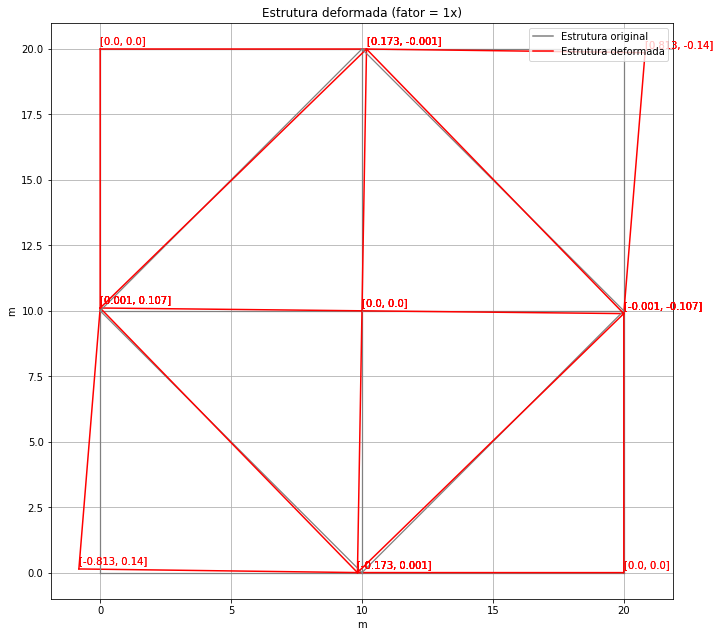

In [7]:
# Plotar estrutura deformada:
fig = plt.figure() 
axes = fig.add_axes([0.1, 0.1, 2,2]) 
fig.gca().set_aspect('equal', adjustable='box')

# Plotagem dos elementos:
for mbr in members:
    node_i = mbr[0]                   # Nó inicial do elemento
    node_j = mbr[1]                   # Nó final do elemento
    ix = nodes[node_i - 1, 0]         # Posição inicial do grau de liberdade horizontal do nó i
    iy = nodes[node_i - 1, 1]         # Posição inicial do grau de liberdade vertical do nó i
    jx = nodes[node_j - 1, 0]         # Posição inicial do grau de liberdade horizontal do nó j
    jy = nodes[node_j - 1, 1]         # Posição inicial do grau de liberdade vertical do nó j
    ia = 2 * node_i - 2               # Grau de liberdade horizontal do nó i
    ib = 2 * node_i - 1               # Grau de liberdade vertical do nó i
    ja = 2 * node_j - 2               # Grau de liberdade horizontal do nó j
    jb = 2 * node_j - 1               # Grau de liberdade vertical do nó j
    
    desl_ia = round(float(Us[ia]), 3) # Deslocamento do GL ia
    desl_ib = round(float(Us[ib]), 3) # Deslocamento do GL ib
    desl_ja = round(float(Us[ja]), 3) # Deslocamento do GL ja
    desl_jb = round(float(Us[jb]), 3) # Deslocamento do GL jb
    
    # Elemento indeformado:
    axes.plot([ix, jx], [iy, jy], 'grey', lw = 1.25)
    
    # Elemento deformado
    axes.plot([ix + Us[ia] * fator, jx + Us[ja] * fator],
              [iy + Us[ib] * fator, jy + Us[jb] * fator], 'r')
    
    # Texto com os deslocamentos nodais:
    axes.text(ix + Us[ia] * fator, magn/100 + iy + Us[ib], f'[{desl_ia}, {desl_ib}]', c='r')
    axes.text(jx + Us[ja] * fator, magn/100 + jy + Us[jb], f'[{desl_ja}, {desl_jb}]', c='r')

# Legendas:
axes.plot([0, 0], [0, 0], 'grey', label = 'Estrutura original')
axes.plot([0, 0], [0, 0], 'r', label = 'Estrutura deformada')
plt.legend()
axes.set_xlabel('m')
axes.set_ylabel('m')
axes.set_title(f'Estrutura deformada (fator = {fator}x)')
axes.grid()
plt.show()

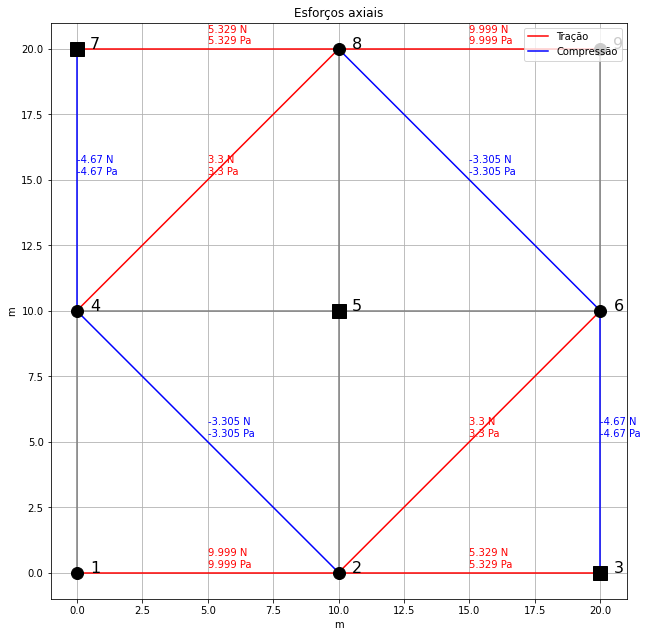

In [8]:
# Plotar tensões axiais:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 2, 2])
fig.gca().set_aspect('equal', adjustable='box')

# Plotagem dos elementos:
for n, mbr in enumerate(members):
    node_i = mbr[0]           # Nó inicial do elemento
    node_j = mbr[1]           # Nó final do elemento
    ix = nodes[node_i - 1, 0] # Posição inicial do grau de liberdade horizontal do nó i
    iy = nodes[node_i - 1, 1] # Posição inicial do grau de liberdade vertical do nó i
    jx = nodes[node_j - 1, 0] # Posição inicial do grau de liberdade horizontal do nó j
    jy = nodes[node_j - 1, 1] # Posição inicial do grau de liberdade vertical do nó j
    ia = 2 * node_i - 2       # Grau de liberdade horizontal do nó i
    ib = 2 * node_i - 1       # Grau de liberdade vertical do nó i
    ja = 2 * node_j - 2       # Grau de liberdade horizontal do nó j
    jb = 2 * node_j - 1       # Grau de liberdade vertical do nó j
    
    # Plota os elementos e os valores das tensões:
    if abs(MF[n]) < 0.005:
        axes.plot([ix, jx], [iy, jy], 'grey') # Sem esforço
    elif MF[n] > 0:
        axes.plot([ix, jx], [iy, jy], 'r')    # Tração
        axes.text((ix + jx)/2, magn/100 + (iy + jy)/2,
                  f'{round(MF[n], 3)} N\n{round(MF[n]/A, 3)} Pa', c='r')
    else:
        axes.plot([ix, jx], [iy, jy], 'b')    # Compressão
        axes.text((ix + jx)/2, magn/100 + (iy + jy)/2,
                  f'{round(MF[n], 3)} N\n{round(MF[n]/A, 3)} Pa', c='b')
        
# Plotagem dos nós:
dof = 0
num = 1
for node in nodes:
    # Verifica se o nó tem algum grau de liberdade restringido:
    if dof in restrainedIndex and dof+1 in restrainedIndex: # Restrição em X e Y
        axes.plot([node[0]], [node[1]], 'ks', ms=14)
    elif dof in restrainedIndex:                            # Restrição somente em X
        axes.plot([node[0]], [node[1]], 'k>', ms=14)
    elif dof+1 in restrainedIndex:                          # Restrição somente em Y
        axes.plot([node[0]], [node[1]], 'k^', ms=14)
    else:                                                   # Nó sem restrições
        axes.plot([node[0]], [node[1]], 'ko', ms=12)
    
    axes.text(node[0] + magn/40, node[1], num, size=16)
    
    dof += 2
    num += 1

# Legendas:
axes.plot([0, 0], [0, 0], 'r', label='Tração')     # Legenda para tração
axes.plot([0, 0], [0, 0], 'b', label='Compressão') # Legenda para compressão
plt.legend()
axes.set_xlabel('m')
axes.set_ylabel('m')
axes.set_title('Esforços axiais')
axes.grid()
plt.show()

# Resumo dos resultados

In [9]:
# Reações de apoio:
print("Reações de apoio:")
for i in np.arange(0, len(restrainedIndex)):
    index = restrainedIndex[i]
    print(f'Grau de liberdade {index}: {round(FG[index].item(), 3)} N')

# Esforços axiais:
print("\nEsforços axiais:")
for n, mbr in enumerate(members):
    print(f'Elemento {n+1} (nós {mbr[0]} a {mbr[1]}): {round(MF[n], 3)} N')

# Tensões normais:
print("\nTensões normais:")
for n, mbr in enumerate(members):
    print(f'Elemento {n+1} (nós {mbr[0]} a {mbr[1]}): {round(MF[n]/A, 3)} Pa')

# Deformações plásticas:
print("\nDeformações plásticas:")
for n, mbr in enumerate(members):
    print(f'Elemento {n+1} (nós {mbr[0]} a {mbr[1]}): {round(ep[n] * 1000, 3)} ‰')
    
# Deslocamentos nodais:
print("\nDeslocamentos nodais:")
for n,node in enumerate(nodes):
    ix = 2 * (n+1) - 2
    iy = 2 * (n+1) - 1
    
    ux = round(float(Us[ix]) * 1000, 4)
    uy = round(float(Us[iy]) * 1000, 4)
    
    print(f'Nó {n+1}: Ux = {ux} mm, Uy = {uy} mm')

print(f'\nTotal de iterações na análise = {total_iter}\n')

Reações de apoio:
Grau de liberdade 4: 5.329 N
Grau de liberdade 5: 4.67 N
Grau de liberdade 8: 0.0 N
Grau de liberdade 9: 0.0 N
Grau de liberdade 12: -5.329 N
Grau de liberdade 13: -4.67 N

Esforços axiais:
Elemento 1 (nós 1 a 2): 9.999 N
Elemento 2 (nós 2 a 3): 5.329 N
Elemento 3 (nós 4 a 5): 0.003 N
Elemento 4 (nós 5 a 6): 0.003 N
Elemento 5 (nós 7 a 8): 5.329 N
Elemento 6 (nós 8 a 9): 9.999 N
Elemento 7 (nós 1 a 4): 0.0 N
Elemento 8 (nós 4 a 7): -4.67 N
Elemento 9 (nós 2 a 5): 0.003 N
Elemento 10 (nós 5 a 8): 0.003 N
Elemento 11 (nós 3 a 6): -4.67 N
Elemento 12 (nós 6 a 9): 0.0 N
Elemento 13 (nós 2 a 4): -3.305 N
Elemento 14 (nós 2 a 6): 3.3 N
Elemento 15 (nós 4 a 8): 3.3 N
Elemento 16 (nós 6 a 8): -3.305 N

Tensões normais:
Elemento 1 (nós 1 a 2): 9.999 Pa
Elemento 2 (nós 2 a 3): 5.329 Pa
Elemento 3 (nós 4 a 5): 0.003 Pa
Elemento 4 (nós 5 a 6): 0.003 Pa
Elemento 5 (nós 7 a 8): 5.329 Pa
Elemento 6 (nós 8 a 9): 9.999 Pa
Elemento 7 (nós 1 a 4): 0.0 Pa
Elemento 8 (nós 4 a 7): -4.67 Pa